In [53]:
import pandas as pd
import os
import json
import datetime 
import numpy as np
import sys
import datetime
from dateutil.relativedelta import relativedelta

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
	sys.path.append(module_path)
 
from prafe.utils import *
from prafe.universe import Universe
from prafe.portfolio import Portfolio
from prafe.evaluation import Evaluator
from prafe.constraint import *
from prafe.objective import *

In [54]:
class Argument(object):
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

argments = {
    'data_path': "../NCSOFT/financial_data",
    # 'result_path': "results_no_logReturn_copy",
    'result_path': "results_no_logReturn_copy",
    'start_date': "2018-01-02",
    'end_date': "2023-04-28",
    'cardinality': 40,
    'index_type': "s&p100",
    'month_increment': 3,
    'backtesting': True,
    # 'method': "SLSQP"
    }

args = Argument(**argments)

solutions = ['SNN_None']
# solutions = ['lagrange_ours_SLSQP', 'lagrange_ours2_SLSQP', 'lagrange_forward_SLSQP', 'SNN_None'] 

In [55]:
df_price, df_return, df_index, start_date, end_date, start_year, end_year = read_data(args)
K = args.cardinality

In [56]:
index_type = args.index_type
if index_type == "kospi100":
    df_index = df_index['IKS100'].pct_change().iloc[1:].fillna(value=0.0)
    index_stocks_list = json.load(open(args.data_path + '/stock_list.json'))[index_type][args.start_date]
elif index_type == "s&p500" or index_type == "s&p100" or index_type == "nasdaq100":
    df_index = df_index['Adj Close'].pct_change().iloc[1:].fillna(value=0.0)
    index_stocks_list = df_price.dropna(axis=1).columns.tolist()
elif index_type == "kosdaq150":
    df_index = df_index['IKQ150'].pct_change().iloc[1:].fillna(value=0.0)
    index_stocks_list = json.load(open(args.data_path + '/stock_list.json'))[index_type][args.start_date]

In [57]:
# Get the universe
universe = Universe(args = args, df_price= df_price, df_return=df_return, df_index = df_index)

universe = universe.get_trimmed_universe_by_stocks(list_of_stock_codes=index_stocks_list)

print(universe._get_universe_datetime_info()) # print the universe datetime info


{'start': Timestamp('2018-01-02 00:00:00'), 'end': Timestamp('2023-12-29 00:00:00')}


In [58]:
# For Monthly Portfolio
if args.month_increment is not None:
    time_increment = relativedelta(months=args.month_increment)
# For Daily/Weekly Portfolio
elif args.day_increment is not None:
    time_increment = datetime.timedelta(days=args.day_increment)
    
portfolio_duration = relativedelta(years=1)

In [59]:
cumulative_return = {}
volatility = {}
sharpe_ratios = {}
MDD = {}
min = {}
sec = {}

for solution in solutions:
    cumulative_return[solution] = []
    volatility[solution] = []
    sharpe_ratios[solution] = []
    MDD[solution] = []
    min[solution] = []
    sec[solution] = []
    
import pickle

with open(f'./backtesting_' + args.result_path + f'/end_date_list_{args.index_type}.pkl', 'rb') as f:
    end_date_list = pickle.load(f)
    


In [60]:
idx = 0
current_date = start_date
current_to_end = current_date + portfolio_duration - pd.Timedelta(days=1)
rebalancing_date = current_date + time_increment
rebalancing = "Start"
# backtesting
while current_to_end <= end_date :
    # print(f"rebalancing date: {rebalancing_date}")
    # print("current_to_end:", current_to_end)
    # print("current:", current_date)
    # print("end_date:", end_date)
    if args.backtesting:
        if not universe.is_valid_date(rebalancing_date):
            rebalancing_date += pd.Timedelta(days=1)
            continue
        if not universe.is_valid_date(current_date):
            current_date += pd.Timedelta(days=1)
            current_to_end = current_date + portfolio_duration - pd.Timedelta(days=1)
            continue
        new_universe = universe.get_trimmed_universe_by_time(start_datetime=current_date, end_datetime=current_to_end)
    else:
        new_universe = universe
        
    for solution in solutions:
        store_path = os.path.join(args.result_path, f'{args.index_type}_{args.start_date}_{args.end_date}', str(args.cardinality), solution)
        
        formatted_start_date = current_date.strftime('%Y-%m-%d')
        formatted_end_date = current_to_end.strftime('%Y-%m-%d')
        
        df = pd.read_csv(store_path + f'/{idx+1}th_evaulation_{formatted_start_date}_{formatted_end_date}.csv')
        # print(store_path + f'/{idx+1}th_evaulation_{formatted_start_date}_{formatted_end_date}.csv')
        
        cumulative_return[solution].append(df['Cumulative Return'].values[0])
        volatility[solution].append(df['Volatility'].values[0])
        sharpe_ratios[solution].append(df['Sharpe Ratio'].values[0])
        MDD[solution].append(df['MDD'].values[0])
        
        # print(cumulative_return)
        # raise Exception("")
        
        if rebalancing == "Start" or rebalancing == True :
            # Rebalancing
            print()
            print(f"{current_date} --> Rebalancing weight!")
            print()
            rebalancing = False
            min[solution].append(df['Minutes'].values[0])
            sec[solution].append(df['Seconds'].values[0])

    if not args.backtesting:
        break
    
    current_date += pd.Timedelta(days=1)
    current_to_end = current_date + portfolio_duration - pd.Timedelta(days=1)
    idx += 1
    
print(cumulative_return)
print(volatility)
print(sharpe_ratios)
print(MDD)
print(min)
print(sec)


2018-01-02 00:00:00 --> Rebalancing weight!

{'SNN_None': [-0.0036173167088475, -0.0036173167088475, -0.0364793614222158, -0.0061780229721775, -0.005183218358727, 0.0002791354137179, 0.0060953185009101, 0.0104552785089257, 0.0032048220952257, 0.0036661509656104, 0.0095247790258267, 0.0102549352315543, 0.0220331473888697, 0.01883809468366, -0.005973053823304, -0.0096905716087393, -0.0106178870571846, -0.0052321153860766, -0.0288953401429502, -0.0320725615760563, -0.0080666303266497, -0.0032824423226221, -0.0019242591965829, 0.0240340472829247, 0.0658253814206445, 0.0482159852699713, 0.0418466804044943, 0.081763330026946, 0.0702061047438766, 0.0699904964805267, 0.0670264965346055, 0.0435057765065731, 0.0443369513583651, 0.0448861558069728, 0.0507858211186152, 0.056080157803339, 0.0604186332721335, 0.0434493034739563, 0.0306673494560726, 0.0448765908671768, 0.0523432068909803, 0.0718631964272357, 0.0623359987792805, 0.0497075258599668, 0.0395821640988273, 0.0321172037474291, 0.0290354558

In [61]:
for solution in solutions:
    mean_cumulative_return = np.mean(cumulative_return[solution])
    mean_volatility = np.mean(volatility[solution])
    mean_sharpe_ratios = np.mean(sharpe_ratios[solution])
    mean_MDD = np.mean(MDD[solution])
    
    print()
    print(solution)
    print(f'mean_cumulative_return: {mean_cumulative_return}')
    print(f'mean_volatility: {mean_volatility}')
    print(f'mean_sharpe_ratios: {mean_sharpe_ratios}')
    print(f'mean_MDD: {mean_MDD}')


SNN_None
mean_cumulative_return: 0.173221517817697
mean_volatility: 0.092096625857406
mean_sharpe_ratios: 0.6203695521272284
mean_MDD: 0.22433415819990618


In [62]:
for solution in solutions:
    mean_min = np.mean(min[solution])
    mean_sec = np.mean(sec[solution])
    
    print()
    print(solution)
    print(f'mean_min: {mean_min}')
    print(f'mean_sec: {mean_sec}')



SNN_None
mean_min: 0.012909460067749
mean_sec: 0.7745668888092041


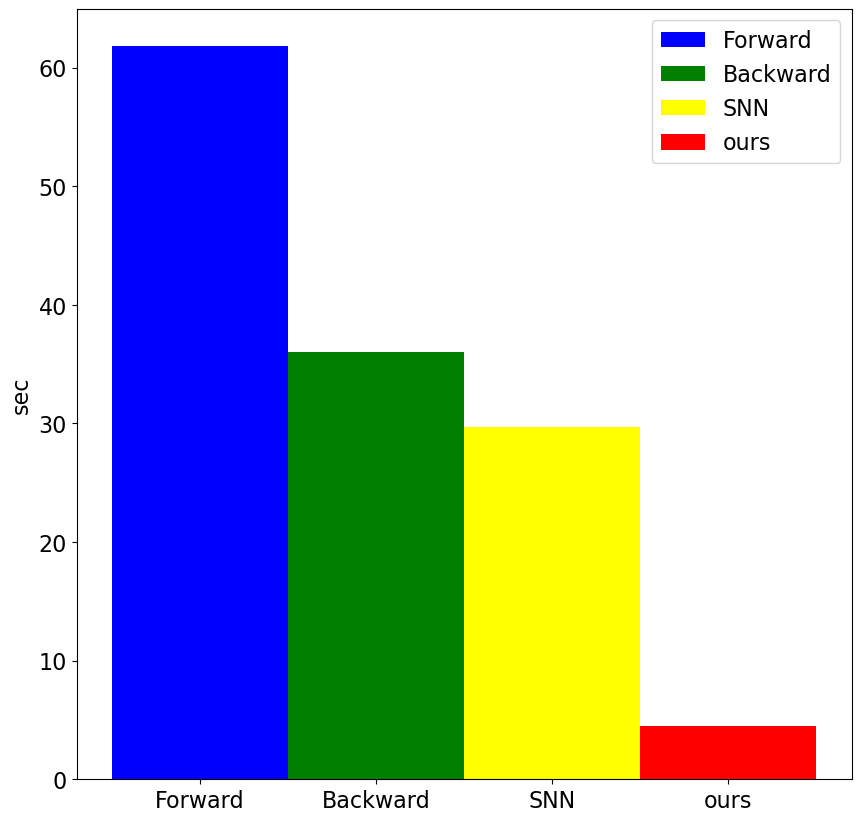

In [63]:
import matplotlib.pyplot as plt

solutions = ['Forward','Backward','SNN','ours']
# secs = [24.2505,44.5050,14.3793,14.8001] #30
secs = [61.8289,36.0348,29.6682,4.4601] #50

plt.figure(figsize=(10,10))
plt.bar(solutions, secs, width=1, label=solutions, color=['blue','green','yellow','red'])

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('sec',fontsize=16)
plt.legend(fontsize=16)
plt.show()

# solution별 cumulative return 값 얻기

In [64]:
class Argument(object):
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

argments = {
    'data_path': "../NCSOFT/financial_data",
    # 'result_path': "results_no_logReturn_copy",
    'result_path': "results_no_logReturn_copy",
    'start_date': "2018-01-02",
    'end_date': "2023-04-28",
    'cardinality': 50,
    'index_type': "s&p100",
    'month_increment': 3,
    'backtesting': True,
    # 'method': "SLSQP"
    }

args = Argument(**argments)


In [65]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

cardinality = args.cardinality

# Lagrange forward
with open(f'./backtesting_{args.result_path}/tracking_indices_{args.index_type}_lagrange_forward_{cardinality}.pkl', 'rb') as f:
    tracking_indices_lagrange_forward = pickle.load(f)
# Lagrange backward
with open(f'./backtesting_{args.result_path}/tracking_indices_{args.index_type}_lagrange_backward_{cardinality}.pkl', 'rb') as f:
    tracking_indices_lagrange_backward = pickle.load(f)
# Lagrange Ours
with open(f'./backtesting_{args.result_path}/tracking_indices_{args.index_type}_lagrange_ours_{cardinality}.pkl', 'rb') as f:
    tracking_indices_lagrange_ours = pickle.load(f)
# SNN
with open(f'./backtesting_{args.result_path}/tracking_indices_{args.index_type}_SNN_{cardinality}.pkl', 'rb') as f:
    tracking_indices_SNN = pickle.load(f)

tracking_indices_lagrange_ours = [row.iloc[-1] for row in tracking_indices_lagrange_ours]
tracking_indices_lagrange_forward = [row.iloc[-1] for row in tracking_indices_lagrange_forward]
tracking_indices_lagrange_backward = [row.iloc[-1] for row in tracking_indices_lagrange_backward]
tracking_indices_SNN = [row.iloc[-1] for row in tracking_indices_SNN]

print(f'CR of forward : {tracking_indices_lagrange_forward}')
print(f'CR of backward : {tracking_indices_lagrange_backward}')
print(f'CR of SNN : {tracking_indices_SNN}')
print(f'CR of ours : {tracking_indices_lagrange_ours}')

print()
print(f'CR mean of forward : {np.mean(tracking_indices_lagrange_forward)}')
print(f'CR mean of backward : {np.mean(tracking_indices_lagrange_backward)}')
print(f'CR mean of SNN : {np.mean(tracking_indices_SNN)}')
print(f'CR mean of ours : {np.mean(tracking_indices_lagrange_ours)}')

CR of forward : [-0.06361040776304211, -0.06361040776304211, -0.09450222376122557, -0.0715384119004664, -0.0733200603416474, -0.06297395844742683, -0.06562780684369827, -0.061519803600479775, -0.07058146864033576, -0.07654974001878362, -0.06340639822032562, -0.0635868936745412, -0.04866807251578626, -0.05400836146765039, -0.07353892013389439, -0.06651804275091816, -0.07343100277443279, -0.07540187633328699, -0.10237708709421595, -0.0965123063604594, -0.07557756428944948, -0.0670488089346918, -0.07044432272071632, -0.042009462052754985, -0.001801452776896889, -0.018952126348575765, -0.025077437600205338, 0.013451409781541142, -0.0008985149063459943, -0.0031826521710104083, -0.004168631631424058, -0.020626984047196276, -0.02309304291261511, -0.02804273325530876, -0.02591642181334749, -0.023423263315285846, -0.018470220075414774, -0.033402807213399735, -0.04429591170757878, -0.028237096758621245, -0.019670727322863457, 0.0030519929599932827, -0.011116986506414343, -0.020710189533884205, -